In [1]:
import xarray as xr
import h5netcdf
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.interpolate as ip
from PIL import Image


In [10]:


with xr.open_dataset('../bathymetrys/manual_baths_4deg_final.nc') as f:
    mask = f['mask'].values[0] > 0
    xt = f['xt'].values
    yt = f['yt'].values

def resize_array(toresize):
    asimg = Image.fromarray(toresize)
    _resize = np.array(asimg.resize((40, 12), resample=0))
    return _resize


def resize_with_time(original):
    meaned = resize_array(np.nanmean(original,axis=2))
    meanhalf = np.nansum(np.transpose([np.flip(meaned[:,20:40])] + [meaned[:,0:20]],(1,2,0)),axis=2)/2
    totalmean = np.append(meanhalf,np.flip(meanhalf,axis=1),axis=1)
    
    return np.transpose(np.repeat([totalmean],90,axis=0),(1,2,0))

def resize_with_monthly(original):
    meaned = resize_array(np.nanmean(original,axis=2))
    return np.transpose(np.repeat([meaned],90,axis=0),(1,2,0))




with xr.open_dataset('forcing_1deg_global.nc') as f:
    orig_sss = f['sss'].values
    orig_sss[orig_sss == 0.] = np.nan
    sss_m = resize_with_monthly(orig_sss)

    orig_sst = f['sst'].values
    orig_sst[orig_sst == 0.] = np.nan
    sst_m = resize_with_monthly(orig_sst)

    orig_tau = f['tau_x'].values
    orig_tau[orig_tau == 0.] = np.nan
    tau_x_m = resize_with_time(orig_tau)
    tau_y_m = np.zeros((12,40,90))

    orig_qn = f['q_net'].values
    orig_qn[orig_qn == 0.] = np.nan
    q_net_m = resize_with_monthly(orig_qn)

    orig_qm = f['dqdt'].values
    orig_qm[orig_qm == 0.] = np.nan
    q_nec_m = resize_with_monthly(orig_qm)

    
with xr.open_dataset('idealized_forcing_4deg.nc') as if4:
    bryanori = np.array([-1,-3,-4.5,-6,-6,-3,0,3,6,9,10,9,3,-0.5,-4.5,-6,-6,-3,-3])
    bryan = np.append(np.flip(bryanori),bryanori)
    xold = np.linspace(-90,90,38)
    newspl = ip.make_interp_spline(xold, bryan, k=3)
    new_tau_x = np.transpose(np.repeat([np.repeat([newspl(if4['yt'].values)],12,axis=0)],90,axis=0),(1,2,0))/1e2
    with h5netcdf.File('idealized_forcing_4deg_new_meaned.nc', 'w') as oc:
        oc._create_dimension("xt", 90)
        oc._create_dimension("yt", 40)
        oc._create_dimension("zt", 15)
        oc._create_dimension("Time", 12)
        oc.create_variable("xt", ("xt",), data=if4['xt'].values)
        oc.create_variable("yt", ("yt",), data=if4['yt'].values)
        oc.create_variable("zt", ("zt",), data=if4['zt'].values)

        #probly look at q_net
        oc.create_variable("q_net", ("Time","yt","xt",), data=q_net_m)
        oc.create_variable("q_nec", ("Time","yt","xt",), data=q_nec_m)
        oc.create_variable("tau_y", ("Time","yt","xt",), data=tau_y_m)
        oc.create_variable("tau_x", ("Time","yt","xt",), data=new_tau_x)
        oc.create_variable("sst", ("Time","yt","xt",), data=sst_m)
        oc.create_variable("sss", ("Time","yt","xt",), data=sss_m)

        oc.create_variable("temperature", ("zt","yt","xt",), data=if4['temperature'].values)
        oc.create_variable("salinity", ("zt","yt","xt",), data=if4['salinity'].values)
        




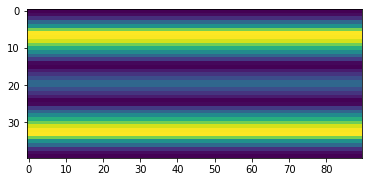